# Fractional Occupations in Psi4
## Written by: Anthony Osborne
For use with the thermal inversion project 

### Import and Set up Section
Memory is likely set way too large but that is safest.

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(15.50e9))
psi4.set_num_threads(10)
psi4.core.clean()

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 


  Memory set to  14.435 GiB by Python driver.
  Threads set to 10 by Python driver.


#### Options to turn off parts of code to save time when running entire notebook. Set to True for on and False for off

In [2]:
Do_Ou_Carter = False # Option used to determine if The Ou-Carter method is used for n2v Only set up for water at the moment
Options_testing = False # Option used to determine if the example fractional occupation is calculated. Leave off unless something major is broken. Might even be better to just remove this cell
index_test = True # Option used to determine if Orbitals and their energies are calculated seperately and printed. Leave off unless something major is broken
Fermi_Testing = False # Option used to determine if the test for the Fermi_to_Frac function is tested. Leave off unless something major is broken. Again another cell that could possibly be removed
Water_testing = True # Option used to determine if fractional occupations for water are to be tested. Turn off to save some time if testing other molecules

#### Molecular Set up
Can and will define mulitple molecules to be tested.

In [3]:
# Molecules should all work
F = psi4.geometry(
    """
    0 2
    F 0.0 0.0 0.0
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="F")
H2O = psi4.geometry(
    """
    0 1
    O        0.15037        0.48699        0.00442
    H        1.11826        0.44171       -0.00585
    H       -0.12848       -0.41805       -0.20079
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Water")
CH4 = psi4.geometry(
    """ 
    C       -0.70207        1.95893        0.00000
    H        0.39013        1.95893       -0.00000
    H       -1.06613        1.99095        1.02924
    H       -1.06613        1.05158       -0.48689
    H       -1.06614        2.83427       -0.54235
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Methane")
CCCC = psi4.geometry(
    """ 
    C        0.60024       -1.20973        0.11111
    C       -0.36574        2.49231        0.54931
    C       -1.34777       -0.08504        3.23689
    C        2.34127        0.92942        2.79869
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Graphite")
Ne = psi4.geometry(
    """
    0 1
    Ne 0.0 0.0 0.0
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Ne")
NH3 =psi4.geometry(
    """
    0 1
    N       -0.58187        0.48713       -0.03712
    H        0.43546        0.50133        0.01948
    H       -0.89347        1.40498        0.27725
    H       -0.89347       -0.17373        0.67317
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Ammonia")


### Functions Used in the calculations

#### Fractional Occupation Options Function

In [4]:
def Psi4Opts(Use=bool, testing=bool, Working=bool, frac_occ=None, frac_val=None):
    '''
    Description: Sets the various options needed for the Psi4 calcualtions.
    Current Capabilities: Does all that it is desired
    Goal: NA
    Note: Pylance does not like the fact that I am using booleans as imputs. Pretty sure that is just a pylance thing
    INPUT:
        Use: Bool 
            True: Sets options Always needs to be true to use Psi4
        testing: Bool
            True: uses a predetermined set of values for the frac_occ and frac_val
            False: Allows for either no fractional occupations to be used or for user specfied values to be used
        Working: Bool
            True: Allows for user specfied values to be used for frac_occ and frac_val
            False: Allows for either no fractional occupations to be used or for examples values to be used
        frac_occ: ndarray
            The absolute orbital indicies to be fractionally occupied
        frac_val: ndarray
            The ammount to fractionally occupy the specified orbitals
    OUTPUT
        No output simply calls a Psi4 option command and sets options to be used
    '''
    options = {
        'basis': 'sto-6g',
        'scf_type': 'direct',
        'reference': 'uhf',
        'df_scf_guess': False,
        'e_convergence': 8,
        "opdm": True,
        'tpdm': True,
        'DFT_SPHERICAL_POINTS': 74,
        'DFT_RADIAL_POINTS': 56,
        'MAXITER' : 1500,
    }

    if Use and testing:
        options.update({
            'frac_start': 1,
            'frac_occ' : [ +3, +4, +5, -3, -4, -5 ],
            'frac_val' : [1.0, 1.0, 1.0, 6.666666666666666e-01, 6.666666666666666e-01, 6.666666666666666e-01],
        })
    if Use and Working:
        options.update({
            'frac_start': 1,
            'frac_occ': frac_occ,
            'frac_val': frac_val,
        })

    psi4.set_options(options)


#### Fractional Occupation function test

In [5]:
dummy_occs = [ +3, +4, +5, +6, -3, -4, -5, -6 ]
dummy_vals = [1.0, 1.0, 1.0, 0.5, 6.666666666666666e-01, 6.666666666666666e-01, 6.666666666666666e-01, 0.5]
if Options_testing == True:
    Psi4Opts(True, False, True, dummy_occs, dummy_vals) # type: ignore #, dummy_occs, dummy_vals) # In order to change from True to False you must restart the kernel
    testEnergy, frac_occd_wfn = psi4.energy('svwn/cc-pvtz', molecule=F, return_wfn=True,) # type: ignore
    #print(testEnergy)
    if testEnergy == -98.91325301570028: # This number came from a Psi4 as an executable run without fractional occupations all other things held constant
        print("No Fractional Occupations were used. Energy is:", testEnergy) 
    else: # This number came from a Psi4 as an executable run with fractional occupations all other things held constant
        print("Fractional Occupation Occured. Energy is:", testEnergy)

##### Inverting with Fractional occupations test For atoms
See [Fluorine and Neon test For Imac](/Users/aosborne3/Desktop/Grad_Research/Code/Examples_Tutorials/Tutorials/PSI4/Fractional_Occupations/Fluorine_N2V_TEST.ipynb)\
See [Fluorine and Neon test For MacBook](/Users/tonyosborne/Desktop/Grad_Research/Code/Examples_Tutorials/Tutorials/PSI4/Fractional_Occupations/Fluorine_N2V_TEST.ipynb)



#### Thermodynamic Properties function

In [6]:
#Thermoproperties function
def thermo_prop(wfn, base_energy, temp, press, Spin_mult, molecular_mass, rotational_constants):
    '''
    Description: Sets the various options needed for the Psi4 calcualtions.
    Current Capabilities: Does what it is supposed to
    Goal: NA
    Note: Might not even be needed. Unsure if this is just messing up the chemical potential or not 
            Do not change the last three lines. I don't understand how that works well enough to fix it. I only know that is is working.
    INPUT:
        wfn: object 
            object allowing for frequency analysis. Required to calculate thermodynamic properties
        base_energy: scalar
            Electronic energy [Eh] at well bottom at 0 [K]
        temp: scalar
            Temperature in [K]. Psi default 298.15. Note that 273.15 is IUPAC STP. 
        press: scalar
            Pressure in [Pa]. Psi default 101325. Note that 100000 is IUPAC STP. 
        Spin_mult: scalar
            Spin multiplicity of molecule under analysis.
        Molecular_Mass: scalar
            Mass in [u] of molecule under analysis. Need to verify the units on data 
        Rotataional_constants: ndarray
            rotational constants in [cm^-1] of molecule under analysis.  Need to varify that data being used for this is in correct units
    OUTPUT
        data_output: Structure Unknown
            Callable library containing the thermodynamic data
    '''
    data_output = psi4.driver.qcdb.vib.thermo(wfn.frequency_analysis, E0=base_energy, T=temp, P=press, sigma=1, molecular_mass=molecular_mass, multiplicity=Spin_mult, rot_const=rotational_constants)
    # Sets first element of data_output as the dictionary and takes care of it
    if isinstance(data_output, tuple) and len(data_output) > 0:
        data_output = data_output[0]  # Assuming the first element is the dictionary
    return data_output

#### Chemical potential function

In [7]:
def chemical_potential(data_set, T, print="n"):
    '''
    Description: Calculates the chemical potential of the specified molecule
    Current Capabilities: It does calculate a chemical potential however it is incorrect. 
            Some of the values used to do the calculation are in Hartree and some are in SI units.
            Currently the highest priorit fix is assigned here.
    Goal: Get working correctly
    Note: Unsure if I am using the correct equation
            
    INPUT:
        data_set: Structure Unknown 
            Is a library containing the various thermodynamic information. Returned by thermo_prop
        T: Scalar
            Temperature in [K] Needs to be converted to electronic temperature using convert_temp
        print: string
            Determines if the extra printing is done. Probably can just remove this
    OUTPUT
        mu: scalar
            Chemical potential of specified molecule
    '''
    R = psi4.constants.R 
    G_tot = data_set['G_tot'].data # Total Gibbs free energy in Eh
    G_tot_J = data_set['G_tot'].data * (4.360 * 10 **(-18)) # Total Gibbs free energy in Eh
    P = data_set['P'].data / 101300          # Pressure P in Pa

    # Calculate chemical potential
    P0 = 100000 / 101300  #  IUPAC STP pressure in Pa 
    mu = G_tot_J + R * T * np.log(P / P0)

    

    # Optionally, print mu
    if print == "y":
        print(f"G_tot: {G_tot}") # type: ignore
        print(f"G_tot in Joules: {G_tot_J}") # type: ignore
        print(f"Chemical potential (mu): {mu} ")  # type: ignore

    return mu


#### Fermi Weighting function
Form of the Fermi weighting is:
$f = (1 + e^{(\epsilon^{\tau}_i - \mu^{\tau})/\tau})^{-1}$

In [8]:
## Converting real temperature to electronic temperature
def convert_temp(temp):
    '''
    Description: Calculates the Fermi-weighting to be used in the frac_val array
    Current Capabilities: As far as I know this works just fine
    Goal: NA
    Note: Temperature is converted to electronic temperature. Chemical potential will be wrong until its function is corrected.
            
    INPUT:
        temp: Scalar
            Temperature in [K] 
    OUTPUT
        tau: scalar
            The electronic temperature 
    '''
    K_b = 3.166811563e-6
    tau = K_b * temp
    return tau

temp = 298.15
print("For a real temperature of", temp, "K the electronic temperature should be: ", convert_temp(temp))

For a real temperature of 298.15 K the electronic temperature should be:  0.00094418486750845


In [9]:
def fermi_weighting(energy, chemical_potential, temperature):
    '''
    Description: Calculates the Fermi-weighting to be used in the frac_val array
    Current Capabilities: As far as I know this works just fine
    Goal: NA
    Note: Temperature is converted to electronic temperature. Chemical potential will be wrong until its function is corrected.
            
    INPUT:
        energy: Scalar
            Energy of the system
        temperature: Scalar
            Temperature in [K] Needs to be converted to electronic temperature using convert_temp
        chemical_potential: Scalar
            Chemical potential of the sytem
    OUTPUT
        mu: scalar
            The fermi weight at the given energy level, chemicial potential and temperature
    '''
    elec_temp = convert_temp(temperature)
    exponent = (energy - chemical_potential)/elec_temp
    expoenential = np.exp(exponent)
    base = 1 + expoenential
    fermi = base**(-1)
    return fermi


#### Getting the Fractional occupation indices

In [10]:
def print_orbital_info(wavefunction):
    '''
    Description: Prints Additional (Probably Uncessary) information about the orbitals
    Current Capabilities: As far as I know this works just fine
    Goal: NA
    Note: Honestly I think this is junk but I hesitate to get rid of it because I dont know if I will need it again
            
    INPUT:
        wavefunction: Type unknown (Variables menu says UHF but that is not a type)
            The wavefunction of the system from Psi4
    OUTPUT
        This function prints information
    '''
    # Get orbital information from wavefunction
    orbital_info = wavefunction.epsilon_a().to_array()  # Orbital energies
    num_occ = wavefunction.nalpha()  # Number of occupied orbitals
    
    # Print out occupied orbital indices and energies
    print("Occupied Orbital Indices and Energies:")
    for i in range(num_occ):
        orbital_index = i + 1  # PSI4 uses 1-based indexing for orbitals
        orbital_energy = orbital_info[i]
        print(f"Orbital {orbital_index}: Energy = {orbital_energy}")


##### Indices testing

In [11]:
if index_test == True:
    Psi4Opts(False, False, False)  # type: ignore
    Molec, name = H2O, "Water"
    Index_test_frequency, index_test_wfn = psi4.frequency('scf', molecule = Molec, return_wfn = True)
    print_orbital_info(index_test_wfn)

Occupied Orbital Indices and Energies:
Orbital 1: Energy = -20.71621328710317
Orbital 2: Energy = -1.6909971937638097
Orbital 3: Energy = -0.9464895777298867
Orbital 4: Energy = -0.5907347551410614
Orbital 5: Energy = -0.5512640389423027


#### Fermi Weights to Fractional Occupation Values

In [12]:
def calc_Fermi_weight(orbital_energies, mu, T):
    '''
    Description: Calculates the Fermi weights for the system at given paramters
    Current Capabilities: As far as I know this works just fine
    Goal: NA
    Note: Pretty sure this works correctly I simply need to add temperature conversion 
            which is done by the convert_temp function above
            
    INPUT:
        orbital_energies: tuple (I should really learn what that means)
            The Orbital energies of the system from Psi4
        mu: scalar
            The (Still incorrect) chemical potential of the system
        T: Scalar
            The temperature in [K] Needs to be converted
    OUTPUT
        fermi_weights: ndarray
            The Fermi Weights of the system at specified mu and tau
    '''
    # Calculate Fermi weightings
    fermi_weights = []
    for energy in orbital_energies:
        f = fermi_weighting(energy, mu, T)
        fermi_weights.append(f)
    return fermi_weights

def fermi_to_frac_val(fermi_weights_list):
    '''
    Description: Takes the Fermi weights and places them into an array to be used for
                 the fractional occupation values
    Current Capabilities: I have not used this in a while since there was an issue. 
                          Pretty sure the issue was that I had this feeding into the wrong place
    Goal: Get this to feed the values into the Psi4 options function correctly
    Note: 
            
    INPUT:
        fermi_weights_list: ndarray
            The set of arrays of fermi weights
    OUTPUT
        frac_val_list: ndarray
            The Fermi Weights as fractional occupation values
    '''
    frac_val_list = []
    for fermi_weights in fermi_weights_list:
        frac_val = []
        for f in fermi_weights:
            if isinstance(f, list):
                frac = []
                for value in f:
                    if value >= 1.0:
                        n = 1.0  # Full occupation (positive fraction)
                    elif value <= 0.0:
                        n = 0.0  # No occupation (zero fraction)
                    else:
                        n = value  # For weights between 0 and 1, use as-is (positive fraction)
                    frac.append(n)
                frac_val.append(frac)
            else:
                if f >= 1.0:
                    n = 1.0  # Full occupation (positive fraction)
                elif f <= 0.0:
                    n = 0.0  # No occupation (zero fraction)
                else:
                    n = f  # For weights between 0 and 1, use as-is (positive fraction)
                frac_val.append(n)
        frac_val_list.append(frac_val)
    return frac_val_list

##### Fermi2Frac testing

In [13]:
if Fermi_Testing == True:
    # Example Fermi weights lists (multiple arrays)
    fermi_weights_list = [
        [0.9, 0.8, 1.0],   # Fermi weights for state 1
        [0.7, 0.6, 0.5],   # Fermi weights for state 2
        [0.95, 0.85, 0.75] # Fermi weights for state 3
    ]

    # Convert Fermi weights to fractional occupations
    frac_occ_list = fermi_to_frac_val(fermi_weights_list)

    # Print fractional occupations
    for i, frac_occ in enumerate(frac_occ_list):
        print(f"Fractional Occupations for state {i+1}:")
        for j, n in enumerate(frac_occ):
            print(f"  Orbital {j+1}: {n}")


#### Printing Function so I don't have to keep copying large cells

In [14]:
def print_big_info(orbital_energies, fermi_weights, frac_val_list, print_orb_energies=bool):
    '''
    Description: Printing function that was intended to save lines when applying to molecule 
                 (not sure it actually save that much space)
    Current Capabilities: Works correctly AFAIK
    Goal: N/A
    Note: 
            
    INPUT:
        orbital_energies: ndarray
            The orbital energies of the system (from Psi4)
        print_orb_energies: boolean
            Determines if extra printing is done
        fermi_weights_list: ndarray
            The set of arrays of fermi weights
        frac_val_list: ndarray
            The Fermi Weights as fractional occupation values
    OUTPUT
        This function only prints does not return anything
    '''
    if print_orb_energies:
        print("Orbital energies for each KS State:")
        for i, energy in enumerate(orbital_energies):
            print(f"State {i+1}: {energy} Hartree")
    # Print Fermi weightings
    print("Fermi weightings for each KS state:")
    for i, f in enumerate(fermi_weights):
        print(f"State {i+1}: f = {f}")
    #Print out fractional occupations
    for i, frac_val in enumerate(frac_val_list):
        print(f"Fractional Occupation Values for state {i+1}:")
        for j, n in enumerate(frac_val):
            print(f"  Orbital {j+1}: {n}")

### Regular SCF (No Fractional Occupations) of Water

#### Calculating the energy for water

In [15]:
Psi4Opts(False, False, False)  # type: ignore
Molec, name = H2O, "Water"
Water_Energy, Water_wfn = psi4.energy("svwn/cc-pvtz", molecule = Molec, return_wfn = True, write_orbitals=('test.dat', True)) # type: ignore
Water_frequency, Water_wfn2 = psi4.frequency("svwn/cc-pvtz", molecule = Molec, return_wfn = True)
print("The total energy of the specified", name, "molecule is:", Water_Energy)

The total energy of the specified Water molecule is: -74.70019301969207


#### Using the energy of water to calculate thermodynamic properties 
then using those properties to calculate the chemical potential and ultimately the Fermi weighting

In [16]:
#rot_const = np.array([27.87700, 14.51200, 9.28500]) # From https://cccbdb.nist.gov/exp2x.asp?casno=7732185
#T =  298.15
#P = 101325
#water_thermo_data = thermo_prop(Water_wfn2, Water_frequency, T, P, 18, 1, rot_const)
#data_output, lib = psi4.driver.qcdb.vib.thermo(Water_wfn2.frequency_analysis, E0=Water_frequency, T=T, P=P, sigma=1, molecular_mass=18, multiplicity=1, rot_const=rot_const)
#print(lib)
#print(water_thermo_data)
#Pressure = Pressure_Printer(water_thermo_data) # type: ignore
#Water_mu = chemical_potential(water_thermo_data, T)
#print(f"The chemical potential of the system is: mu = {Water_mu}")
#print(Water_wfn.same_a_b_orbs())
Water_orbital_energies_alpha = Water_wfn.epsilon_a().np
Water_Orbitals_alpha = Water_wfn.Ca().np
#print(Water_wfn.nalpha())
#print(Water_wfn.nbeta())
print(Water_orbital_energies_alpha)
print(Water_Orbitals_alpha)
#Water_Fermi_weights_alpha = calc_Fermi_weight(Water_orbital_energies_alpha, Water_mu, T)
#print(Water_Fermi_weights_alpha)
#frac_val_list_alpha = fermi_to_frac_val(Water_Fermi_weights_alpha) 
#print_big_info(Water_orbital_energies_alpha, Water_Fermi_weights_alpha, frac_val_list_alpha, False)  # type: ignore

[-18.56191295  -1.21348764  -0.70410214  -0.39425457  -0.3293642
   0.04395905   0.12070445   0.38966654   0.43626963   0.48102808
   0.59332436   0.69187669   0.70418125   0.70608843   0.83970985
   0.85244611   1.18626792   1.49689709   1.70619534   1.72190323
   1.76162037   1.82499143   1.83340346   2.31676535   2.87319124
   2.95296605   2.99078862   3.14783388   3.21341889   3.27518217
   3.37130848   3.64620076   3.71603939   3.85481667   4.16584134
   4.26238919   4.29334333   4.56642587   4.66258792   4.82917065
   5.18075501   5.23068294   5.85726614   5.96208855   6.02104748
   6.1237194    6.54377161   6.57036437   6.63747612   7.85748678
   7.92419024   8.37912184   8.7692471    8.91982657   9.25378189
   9.78502104  11.85600384  21.13016847]
[[ 9.54965881e-01  5.60308250e-02  1.39720531e-08 ...  1.05230550e-01
   4.06217736e-07  6.46887386e+00]
 [-1.91000833e-02 -4.34750903e-01  5.84779092e-08 ... -7.72366531e-01
  -1.06391709e-07  1.12813797e+01]
 [ 8.00997991e-02 -1.050

In [17]:
Water_orbital_energies_beta = Water_wfn.epsilon_b().nph
#print(Water_orbital_energies_beta)
Water_Fermi_weights_beta = calc_Fermi_weight(Water_orbital_energies_beta, Water_mu, T)
frac_val_list_beta = fermi_to_frac_val(Water_Fermi_weights_beta) 
print_big_info(Water_orbital_energies_beta, Water_Fermi_weights_beta, frac_val_list_beta, True)  # type: ignore

NameError: name 'Water_mu' is not defined

### Fractional Occupations for Water

#### Manually trying new factional occupations

In [ ]:
#test_Occs = [+1, +2, -1, -2] 
#Test_values = [1, 1, 0.48111183, 0.46503572]
# Last working set: 1 - 6 
#test_Occs = [+1, +2, +3, +4, +5, +6, -1, -2, -3, -4, -5, -6] 
#Test_values = [1, 1, 1, 1, 1, 1, 0.48111183, 0.46503572, 0.4654729202742443, 0.4652103301619441, 0.46515678040514274, 0.46484442384199415]
# Currently testing set: 3-8 
# 8th is a virtual orbital I think 
test_Occs = [+3, +4, +5, +6, +7, +8, -3, -4, -5, -6, -7, -8] 
Test_values = [1, 1, 1, 1, 1, 1, 0.4654729202742443, 0.4652103301619441, 0.46515678040514274, 0.46484442384199415, 0.4647808121454412, 0.46455717961153353]
#Three_Occs = [+1, +2, +3, -1, -2, -3] 
#Three_values = [1, 1, 1, 0.48111183, 0.46503572, 0.46347614]
I_Fixed_it = True
if I_Fixed_it == False:
    raise Exception("There is an error in the way you are loading the new occupations and values")
if Water_testing == True:
    Psi4Opts(True, False, True, test_Occs, Test_values) # type: ignore # In order to change from True to False you must restart the kernel
    Water_Frac_Energy, Water_Frac_wfn = psi4.properties("svwn/cc-pvtz", molecule=H2O, return_wfn=True) # type: ignore
    #Psi4Opts(True, False, True, Three_Occs, Three_values) # In order to change from True to False you must restart the kernel
    #Three_Water_Frac_Energy, Three_Water_Frac_wfn = psi4.properties("svwn/cc-pvtz", molecule=H2O, return_wfn=True)
    #Water_test_frequency, Water_wfn2 = psi4.frequency('scf', molecule = Molec, return_wfn = True)
    #frequency, wfn2 = psi4.frequency('scf', molecule = F, return_wfn = True)
    if Water_Frac_Energy == Water_frequency:
        print("No Fractional Occupations were used. Energy is:", Water_Frac_Energy) 
    else:
        print("Fractional Occupation Occured occured. Energy is:", Water_Frac_Energy)
        print(f"Regular (non fractionally occupied) energy is; {Water_frequency}")

Fractional Occupation Occured occured. Energy is: -72.4791916706624
Regular (non fractionally occupied) energy is; -74.7001930196935


#### Inverting Using Direct method

In [ ]:
Invert_Water = n2v.Inverter.from_wfn(Water_Frac_wfn)
# Build 1D grid
x = np.linspace(-3,5,801)
y = [0]
z = [0]
grid, shape = Invert_Water.eng.grid.generate_grid(x,y,z)

# Run the calculation with requested grid
vxc_inverted_Water = Invert_Water.invert('direct', grid=grid, correction=False)
vxc_inverted_corr_Water = Invert_Water.invert('direct', grid=grid, correction=True)
#Compare the performance of direct and reversed calculation of vxc. 
vxc0_Water = Invert_Water.eng.grid.vxc(Da=Water_Frac_wfn.Da().np, Db=Water_Frac_wfn.Db().np, grid=grid) # type: ignore
#Invert_Water.invert("mRKS", vxc_grid=grid, opt_max_iter=30, frac_old=0.8, init="scan", sing=(1e-7, 1e-4, 1e-7, 1e-4))

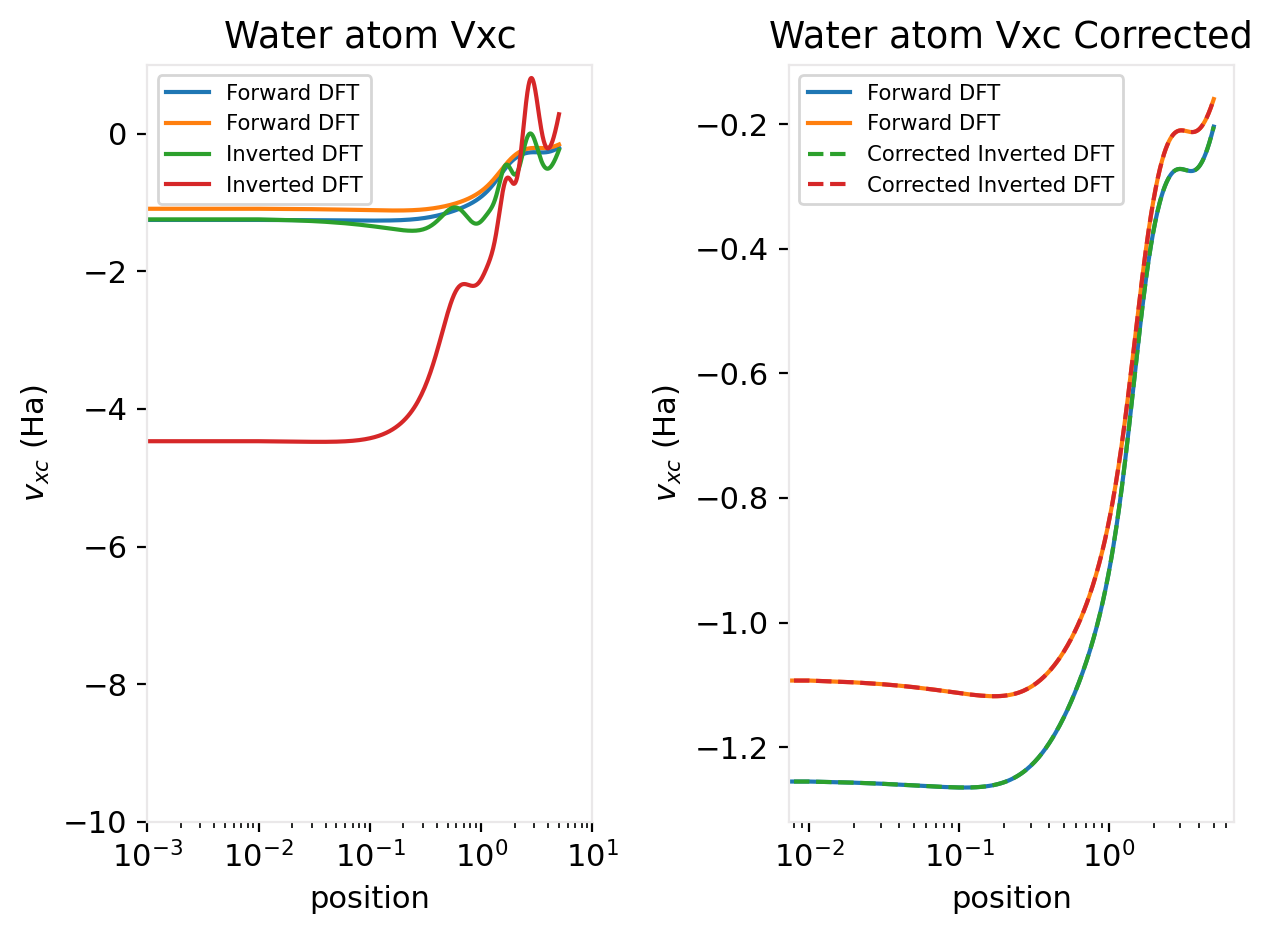

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=200)
#---------------> Data
ax[0].plot(x, vxc0_Water, label="Forward DFT")
ax[0].plot(x, vxc_inverted_Water, label="Inverted DFT")
ax[1].plot(x, vxc0_Water, label="Forward DFT")
ax[1].plot(x, vxc_inverted_corr_Water, '--',label="Corrected Inverted DFT")
#---------------> Formatting
#-------> Labels
ax[0].set_xlabel('position')
ax[0].set_ylabel('$v_{xc}$ (Ha)')
ax[0].legend(loc='best', fontsize='x-small')
ax[0].set_xlabel('position')
ax[1].set_xlabel('position')
ax[1].set_ylabel('$v_{xc}$ (Ha)')
ax[1].legend(loc='best', fontsize='x-small')
#-------> Titles
ax[0].title.set_text('Water atom Vxc')
ax[1].title.set_text('Water atom Vxc Corrected')
#-------> Sizing
ax[0].set_xlim(0.001,10)
ax[0].set_ylim(-10, 1)
#ax[1].set_xlim(0.001,10)
#ax[1].set_ylim(-10, 1)
#ax[0, 0].set_box_aspect(1)
#ax[0, 1].set_box_aspect(1)
#ax[1, 1].set_box_aspect(1)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
fig.tight_layout()
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.00
#fig.suptitle("Water Molecule Fractionally Occupied Direct Vxc")

#### Inverting using the Ou-Carter method

In [ ]:
if Do_Ou_Carter == True:
    # Build the plotting grid for vxc:
    x_OC = np.linspace(-5,5,1501) + 1e-7
    y_OC = [0]
    z_OC = [0]
    grid_OC, shape_OC = Invert_Water.eng.grid.generate_grid(x_OC,y_OC,z_OC)
    v_OC = Invert_Water.invert("OC", vxc_grid=grid_OC, frac_old=0.9, init="SCAN") #opt_max_iter=29, frac_old=0.9, init="SCAN")
    ## Turn grid into psi4 blocks:
    #grid_info = Invert_Water.eng.grid.grid_to_blocks(grid)  # turing grid into psi4 block infomation
    #grid_info[-1].set_pointers(Water_wfn.Da())

    ## Get exact and effective external potential
    #vext = Invert_Water.eng.grid.esp(grid=grid_info)[0]
    #vext_eff = Invert_Water._get_optimized_external_potential(grid_info=grid_info,)[-1]
    #---------------> Plot
    fig, ax = plt.subplots(1, 1, dpi=200)
    #---------------> Data

    ax.axhline(y=0, ls='--', label='y=0')
    ax.plot(x_OC, v_OC[0].T, label="$v_{xc}$")  # type: ignore
    #---------------> Formatting
    #-------> Labels
    ax.set_xlabel('Position')
    ax.set_ylabel('$v_{ext}$ (Ha)')
    ax.legend()
    #-------> Titles
    ax.title.set_text('Water (Fractionally occupied) $V_{xc}$ Ou_Carter Method')
    #-------> Sizing
    #ax.set_xlim(-5,5)
    #ax.set_ylim(-30, 30)
    # Log limits
    ax.set_xlim(0.001,10)
    ax.set_xscale('log')
    fig.tight_layout()
    #-------> Borders ## Have to run cell twice for this to work no idea why -- AO
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1.00

Inverting with Other methods seems unnecessary and we can not invert a uhf with mRKS

### Testing Code on $NH_3$

In [ ]:
Psi4Opts(False, False, False)  # type: ignore
Molec, name = NH3, "Ammonia"
Ammonia_Energy, Ammonia_wfn = psi4.energy("svwn/cc-pvtz", molecule = Molec, return_wfn = True, write_orbitals=('test.dat', True)) # type: ignore
Ammonia_frequency, Ammonia_wfn2 = psi4.frequency("svwn/cc-pvtz", molecule = Molec, return_wfn = True)
print("The total energy of the specified", name, "molecule is:", Ammonia_Energy)
# 9.44430	9.44430	6.19600

 '9643.4786i']
The total energy of the specified Ammonia molecule is: -52.6291938596389


In [ ]:
rot_const = np.array([9.44430, 9.44430, 6.19600]) # From https://cccbdb.nist.gov/exp2x.asp?casno=7664417&charge=0
T =  298.15
P = 101325
Ammonia_thermo_data = thermo_prop(Ammonia_wfn2, Ammonia_frequency, T, P, 17, rot_const)
Ammonia_mu = chemical_potential(Ammonia_thermo_data, T)
print(f"The chemical potential of the system is: mu = {Ammonia_mu}")
#print(Water_wfn.same_a_b_orbs())
Ammonia_orbital_energies_alpha = Ammonia_wfn.epsilon_a().nph
print_orb_energies = False
Ammonia_Fermi_weights_alpha = calc_Fermi_weight(Ammonia_orbital_energies_alpha, Ammonia_mu, T)
frac_val_list_alpha = fermi_to_frac_val(Ammonia_Fermi_weights_alpha) 
#print_big_info(Ammonia_orbital_energies_alpha, Ammonia_Fermi_weights_alpha, frac_val_list_alpha, False)  # type: ignore

TypeError: thermo_prop() missing 1 required positional argument: 'rotational_constants'

### Testing code on $CH_4$

In [ ]:
Psi4Opts(False, False, False) # type: ignore
raise Exception("Convergence issue Please reevaluate me")
Molec, name = CH4, "Methane"
Methane_energy, Methane_wfn = psi4.energy("svwn/cc-pvtz", molecule = Molec, return_wfn = True, write_orbitals=('test.dat', True)) # type: ignore
Methane_frequency, Methane_wfn2 = psi4.frequency("svwn/cc-pvtz", molecule = Molec, return_wfn = True)
print("The total energy of the specified", name, "molecule is:", Methane_frequency)
rot_const = np.array([5.24120, 5.24120, 5.24120]) #From https://cccbdb.nist.gov/expgeom2.asp?casno=74828&charge=0
T =  298.15
P = 101325
Methane_thermo_data = thermo_prop(Methane_wfn2, Methane_frequency, T, P, 16, rot_const)
Methane_mu = chemical_potential(Methane_thermo_data, T)
print(f"The chemical potential of the system is: mu = {Methane_mu}")
#print("These are not correct you need to update the rotational constants. Also make sure they are correct for all molecules")
Methane_orbital_energies = Methane_wfn.epsilon_a().nph
Methane_Fermi_weights = calc_Fermi_weight(Methane_orbital_energies, Methane_mu, T)
frac_val_list = fermi_to_frac_val(Methane_Fermi_weights)
#print_big_info(Methane_orbital_energies, Methane_Fermi_weights, frac_val_list, False) #type: ignore

### Test for Graphite/Graphene cannot get scf to converge 

In [ ]:
#Psi4Opts(False, False)
#Molec, name = CCCC, "Graphite/Graphene"
#Energy_Graph, wfn_Graph = psi4.energy('scf', molecule = Molec, return_wfn = True, write_orbitals=('test.dat', True))
#frequency_Graph, wfn2_Graph = psi4.frequency('scf', molecule = Molec, return_wfn = True)
#print("The total energy of the specified", name, "molecule is:", frequency_Graph)


In [18]:
## Small inline clean-up to remove those pesky psi.clean files 
%rm psi*.clean

zsh:1: no matches found: psi*.clean
